In [141]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')


In [142]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
#qu1= """
# select * from TBD_COMMON_MAPS_DATA_1
# where risk_agrf120 =1 
# """
#df = pd.read_sql(qu1,connection)
#df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_income_pred.pkl")
#df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_income_pred.csv")

In [143]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_income_pred.pkl")

In [144]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FSTQPD30', 'RISK_AGRF120', 'PRODUCT_GROUP', 'RISK_SCORE', 'RNK',
       'GRID_ID', 'NO_HOUSEHOLD', 'TOTAL_POPULATION', 'TOTAL_MALE',
       'TOTAL_FEMALE', 'LITERACY_TOTAL', 'LITERACY_MALE', 'LITERACY_FEMALE',
       'SEX_RATIO', 'PP_INDEX', 'PROSPERITY_PURCHASING_POWER',
       'PROSPERITY_FOOD_BEVERAGE', 'PROSPERITY_ALCOHOLIC_BEVERAGE',
       'PROSPERITY_TOBACCO', 'PROSPERITY_CLOTHING', 'PROSPERITY_FOOTWEAR',
       'PROSPERITY_FURNITURE_FURNISHIN', 'PROSPERITY_HOUSEHOLD_TEXTILES',
       'PROSPERITY_HOUSEHOLD_APPLIANCE', 'PROSPERITY_HOUSEHOLD_UTENSILS',
       'PROSPERITY_HOUSEHOLD_GARDEN_TO', 'PROSPERITY_HOUSEHOLD_MAINTENAN',
       'PROSPERITY_MEDICAL_PRODUCTS', 'PROSPERITY_ELECTRONICS_IT',
       'PROSPERITY_RECREATION_DURABLES', 'PROSPERITY_TOYS_SPORTS_PETS',
       'PROSPERITY_RECREATIONAL_SERVIC', 'PROSPERITY_BOOKS_STATIONERY',
       'PROSPERITY_CATERING_SERVICES', 'PROSPERITY_PERSONAL_CARE',

In [145]:
df = df[["SKP_CREDIT_CASE","TIME_DECISION_DATE","CUS_LAT","CUS_LONG","RISK_FSTQPD30","RISK_AGRF120",
"PRODUCT_GROUP","RISK_SCORE","GRID_ID","CLIENT_INR_INCOME","SCORE_CB",'PROSPERITY_PURCHASING_POWER']]

In [146]:
df_income = pd.read_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\pred income.csv")

In [147]:
df = df.merge(df_income[["SKP_CREDIT_CASE","PRED_INCOME"]],on = "SKP_CREDIT_CASE")

In [148]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,RISK_SCORE,GRID_ID,CLIENT_INR_INCOME,SCORE_CB,PROSPERITY_PURCHASING_POWER,PRED_INCOME
0,236957321,2019-05-23,22.462850,70.054036,0,1,CD,0.004765,500_00373_03390,22500.0,715.0,147904.9356,19551.741294
1,219519938,2018-12-21,22.461209,70.053191,0,1,CD,0.011997,500_00373_03390,25000.0,715.0,147904.9356,19551.741294
2,236282107,2019-05-17,22.461209,70.053191,0,1,CD,0.009383,500_00373_03390,12000.0,-1.0,147904.9356,19551.741294
3,220201779,2018-12-28,22.459227,70.056789,0,1,CD,0.006077,500_00373_03390,18000.0,-1.0,147904.9356,19551.741294
4,229241528,2019-03-18,22.459227,70.056789,1,1,CD,0.007692,500_00373_03390,20000.0,-1.0,147904.9356,19551.741294


In [149]:
df.dropna(subset = ["RISK_SCORE"], inplace = True)

In [150]:
df.shape

(3669338, 13)

In [151]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")

In [152]:
df = df[df["CLIENT_INR_INCOME"]<df["CLIENT_INR_INCOME"].quantile(0.99)]

In [153]:
df = df[df["CLIENT_INR_INCOME"]!=0]

In [154]:
df["PRED_BY_ACT"] = df["PRED_INCOME"]/df["CLIENT_INR_INCOME"]
df["ACT_BY_PRED"] = df["CLIENT_INR_INCOME"]/df["PRED_INCOME"]

df["PROP_BY_ACT"] = df["PROSPERITY_PURCHASING_POWER"]/df["CLIENT_INR_INCOME"]
df["ACT_BY_PROP"] = df["CLIENT_INR_INCOME"]/df["PROSPERITY_PURCHASING_POWER"]

df["AVG_INCOME"] = (df["PRED_INCOME"]+df["CLIENT_INR_INCOME"])/2

In [155]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2018, 12, 1))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]

In [156]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)


(2141803, 19)
(225724, 19)
(375914, 19)


In [157]:
cols_pred_num=["PRED_BY_ACT","ACT_BY_PRED","PROP_BY_ACT","ACT_BY_PROP","PRED_INCOME","CLIENT_INR_INCOME",
               "PROSPERITY_PURCHASING_POWER","RISK_SCORE","AVG_INCOME"]
cols_pred_cat = []

In [158]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=5, 
                    min_samples=100000)

In [159]:
grouping.fit(df_train[cols_pred_num],
             df_train["RISK_FSTQPD30"],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=10000);

In [160]:
grouping.save(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\my_grouping")

'Grouping saved on 2020-01-29 16:19:18 to file C:\\Users\\aman.khatri91425\\Desktop\\HomeCredit\\Bigdata\\Common Maps KNN\\my_grouping'

In [161]:
data_woe = grouping.transform(df, transform_to='woe', progress_bar=True)

***

### ACT_BY_PRED

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_ACT_BY_PRED,,,,,,,,
"[-inf, 0.7059)",336930.0,27559.0,0.0818,0.1540,0.1576,0.0233,0.0235,0.1573
"[0.7059, 1.1617)",1336220.0,112171.0,0.0839,0.6266,0.6236,-0.0047,-0.0048,0.6239
"[1.1617, 1.3285)",201303.0,17425.0,0.0866,0.0973,0.0937,-0.0379,-0.0383,0.0940
"[1.3285, 1.6006)",167074.0,13979.0,0.0837,0.0781,0.0780,-0.0012,-0.0012,0.0780
"[1.6006, inf)",100276.0,7875.0,0.0785,0.0440,0.0471,0.0670,0.0678,0.0468
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0004
Gini: 0.95


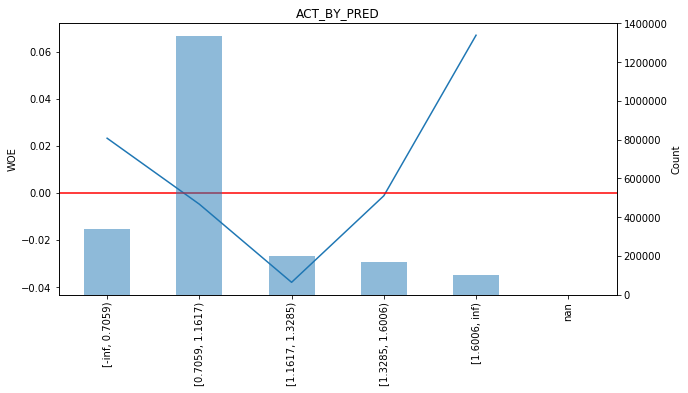

***

### ACT_BY_PROP

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_ACT_BY_PROP,,,,,,,,
"[-inf, 0.06163)",411136.0,33240.0,0.0808,0.1857,0.1925,0.0358,0.0362,0.1920
"[0.06163, 0.06659)",108365.0,9253.0,0.0854,0.0517,0.0505,-0.0231,-0.0234,0.0506
"[0.06659, 0.09796)",683378.0,56615.0,0.0828,0.3163,0.3193,0.0095,0.0096,0.3191
"[0.09796, 0.2435)",828530.0,69975.0,0.0845,0.3909,0.3865,-0.0113,-0.0114,0.3868
"[0.2435, inf)",110394.0,9926.0,0.0899,0.0554,0.0512,-0.0792,-0.0800,0.0515
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0007
Gini: 1.33


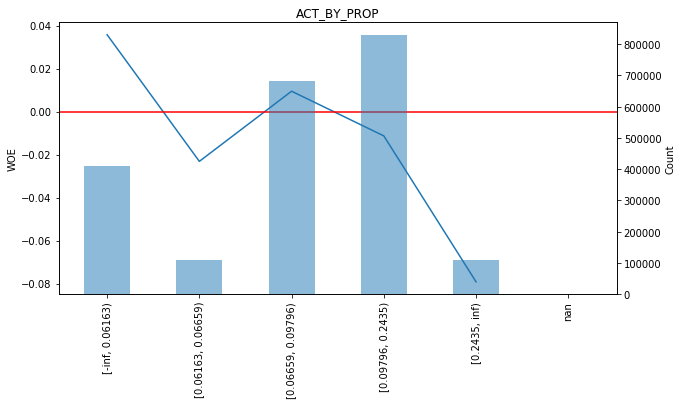

***

### AVG_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_AVG_INCOME,,,,,,,,
"[-inf, 12796.0073)",203354.0,15875.0,0.0781,0.0887,0.0955,0.0734,0.0742,0.0949
"[12796.0073, 14878.4839)",423831.0,34571.0,0.0816,0.1931,0.1983,0.0263,0.0265,0.1979
"[14878.4839, 19543.4004)",1130682.0,94900.0,0.0839,0.5301,0.5277,-0.0045,-0.0046,0.5279
"[19543.4004, 22121.6611)",228097.0,19796.0,0.0868,0.1106,0.1061,-0.0407,-0.0412,0.1065
"[22121.6611, inf)",155839.0,13867.0,0.0890,0.0775,0.0723,-0.0678,-0.0686,0.0728
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0012
Gini: 1.77


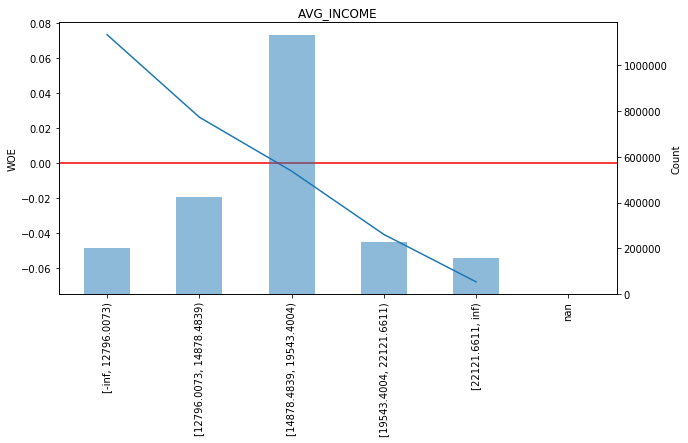

***

### CLIENT_INR_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_CLIENT_INR_INCOME,,,,,,,,
"[-inf, 9805.0)",113657.0,9107.0,0.0801,0.0509,0.0533,0.0454,0.0459,0.0531
"[9805.0, 10260.5)",139249.0,10861.0,0.0780,0.0607,0.0654,0.0743,0.0752,0.0650
"[10260.5, 15999.5)",888423.0,73920.0,0.0832,0.4129,0.4150,0.0049,0.0049,0.4148
"[15999.5, 21498.0)",662986.0,56160.0,0.0847,0.3137,0.3092,-0.0145,-0.0147,0.3095
"[21498.0, inf)",337488.0,28961.0,0.0858,0.1618,0.1572,-0.0285,-0.0288,0.1576
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0007
Gini: 1.27


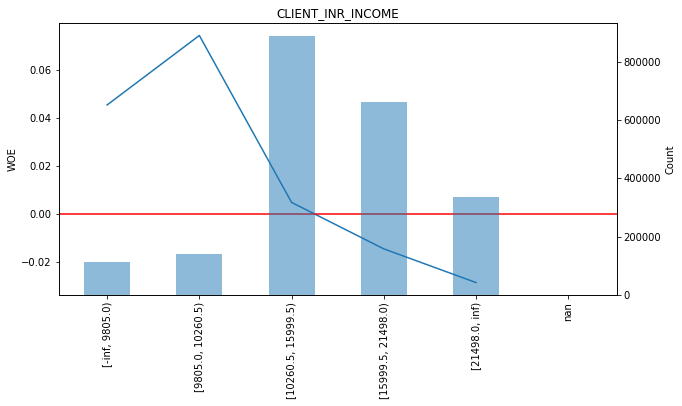

***

### PRED_BY_ACT

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PRED_BY_ACT,,,,,,,,
"[-inf, 0.6247)",100276.0,7875.0,0.0785,0.0440,0.0471,0.0670,0.0678,0.0468
"[0.6247, 0.7527)",167074.0,13979.0,0.0837,0.0781,0.0780,-0.0012,-0.0012,0.0780
"[0.7527, 0.8608)",201303.0,17425.0,0.0866,0.0973,0.0937,-0.0379,-0.0383,0.0940
"[0.8608, 1.4167)",1336220.0,112171.0,0.0839,0.6266,0.6236,-0.0047,-0.0048,0.6239
"[1.4167, inf)",336930.0,27559.0,0.0818,0.1540,0.1576,0.0233,0.0235,0.1573
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0004
Gini: 0.95


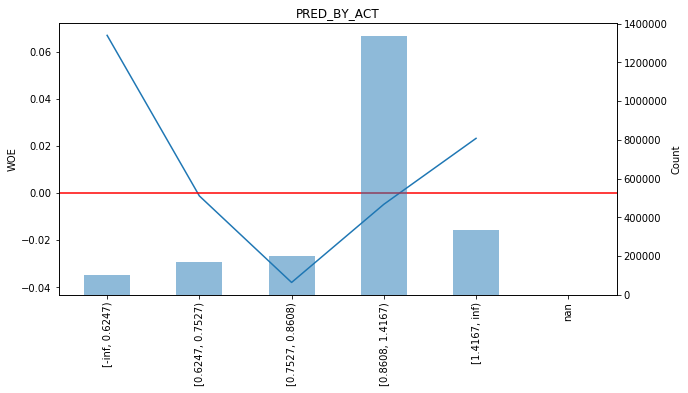

***

### PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PRED_INCOME,,,,,,,,
"[-inf, 13690.1392)",126463.0,9622.0,0.0761,0.0538,0.0595,0.1009,0.1021,0.0590
"[13690.1392, 14786.3857)",274217.0,21946.0,0.0800,0.1226,0.1285,0.0467,0.0472,0.1280
"[14786.3857, 18957.3135)",1370392.0,113276.0,0.0827,0.6328,0.6405,0.0119,0.0121,0.6398
"[18957.3135, 20087.5527)",222559.0,19812.0,0.0890,0.1107,0.1033,-0.0683,-0.0690,0.1039
"[20087.5527, inf)",148172.0,14353.0,0.0969,0.0802,0.0682,-0.1605,-0.1622,0.0692
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0034
Gini: 2.66


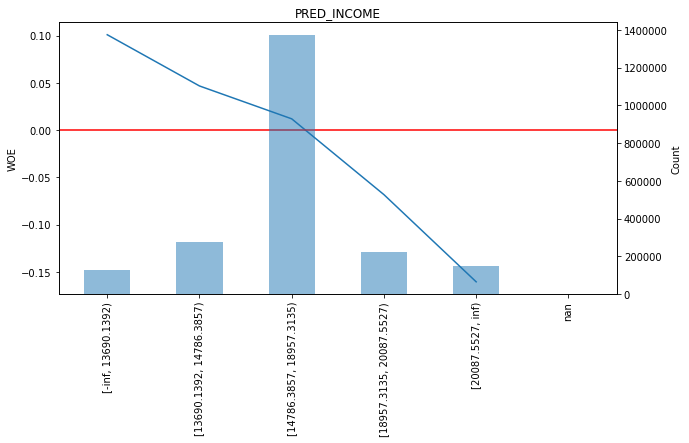

***

### PROP_BY_ACT

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PROP_BY_ACT,,,,,,,,
"[-inf, 4.1061)",110394.0,9926.0,0.0899,0.0554,0.0512,-0.0792,-0.0800,0.0515
"[4.1061, 10.2083)",828530.0,69975.0,0.0845,0.3909,0.3865,-0.0113,-0.0114,0.3868
"[10.2083, 15.0166)",683378.0,56615.0,0.0828,0.3163,0.3193,0.0095,0.0096,0.3191
"[15.0166, 16.2257)",108365.0,9253.0,0.0854,0.0517,0.0505,-0.0231,-0.0234,0.0506
"[16.2257, inf)",411136.0,33240.0,0.0808,0.1857,0.1925,0.0358,0.0362,0.1920
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0007
Gini: 1.33


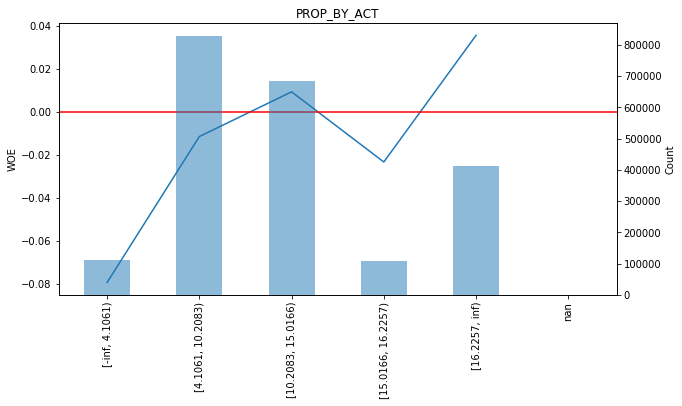

***

### PROSPERITY_PURCHASING_POWER

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PROSPERITY_PURCHASING_POWER,,,,,,,,
"[-inf, 67801.8281)",106181.0,9711.0,0.0915,0.0542,0.0491,-0.0977,-0.0987,0.0496
"[67801.8281, 176891.5859)",932161.0,77262.0,0.0829,0.4316,0.4356,0.0090,0.0091,0.4352
"[176891.5859, 191206.2734)",133567.0,12065.0,0.0903,0.0674,0.0619,-0.0842,-0.0851,0.0624
"[191206.2734, 270523.6562)",719539.0,58491.0,0.0813,0.3267,0.3368,0.0299,0.0303,0.3360
"[270523.6562, inf)",250355.0,21480.0,0.0858,0.1200,0.1166,-0.0283,-0.0286,0.1169
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.0014
Gini: 1.79


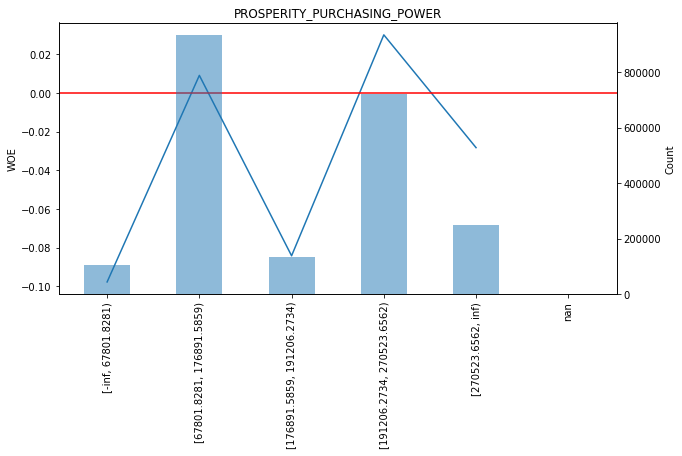

***

### RISK_SCORE

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_RISK_SCORE,,,,,,,,
"[-inf, 0.008173)",696196.0,28076.0,0.0403,0.1568,0.3404,0.7622,0.7749,0.3251
"[0.008173, 0.01688)",811585.0,63580.0,0.0783,0.3552,0.3811,0.0696,0.0704,0.3789
"[0.01688, 0.02396)",314203.0,35076.0,0.1116,0.1959,0.1422,-0.3175,-0.3205,0.1467
"[0.02396, 0.03618)",211245.0,29758.0,0.1409,0.1662,0.0925,-0.5817,-0.5866,0.0986
"[0.03618, inf)",108574.0,22519.0,0.2074,0.1258,0.0438,-1.0468,-1.0541,0.0507
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.3947,0.0000


IV: 0.2909
Gini: 28.98


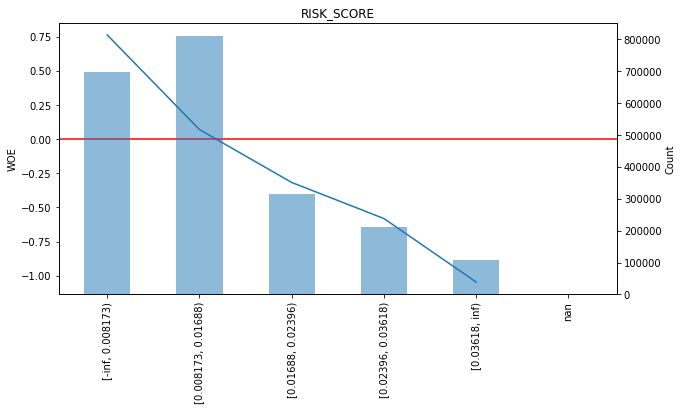

In [162]:
grouping.plot_bins(data=df_train, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask = pd.Series(df_train["CLIENT_INR_INCOME"]>=0),col_target="RISK_FSTQPD30", 
                   output_folder=r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN", col_weight=None)

In [163]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in df:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
df = df.drop(woe_columns_to_replace, axis='columns')
df = df.join(-data_woe)

print('Added WOE variables. Number of columns:',df.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred_num]

Added WOE variables. Number of columns: 28


In [164]:
# Split Train and Test Data Set
df["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df["RISK_SCORE"]]

df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2018, 12, 1))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]

In [165]:
from scoring.metrics import iv,gini,lift
cols_list= cols_woe + cols_pred_num
col_target= 'RISK_FSTQPD30'
power_tab = []
for j in range(0,len(cols_list)):
    power_tab.append({'Name':cols_list[j]
#                    ,'IV Train':iv(df_train[col_target],df_train[cols_list[j]])
                    ,'Gini Train':2*metrics.roc_auc_score(df_train[col_target],df_train[cols_list[j]])-1
#                    ,'IV Validate':iv(df_valid[col_target],df_valid[cols_list[j]])
                    ,'Gini Validate':2*metrics.roc_auc_score(df_valid[col_target],df_valid[cols_list[j]])-1
#                    ,'IV Test':iv(df_test[col_target],df_test[cols_list[j]])
                    ,'Gini Test':2*metrics.roc_auc_score(df_test[col_target],df_test[cols_list[j]])-1
                         })
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name')
power_out = power_out.sort_values('Gini Test',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\covariates.csv")

,Gini Test,Gini Train,Gini Validate
Name,,,
RISK_SCORE,0.248956,0.314862,0.234205
RISK_SCORE_WOE,0.214404,0.289759,0.197883
AVG_INCOME,0.048020,0.018099,0.049594
PRED_INCOME,0.045537,0.027952,0.042014
AVG_INCOME_WOE,0.043631,0.017739,0.045998
PRED_INCOME_WOE,0.040389,0.026563,0.041613
CLIENT_INR_INCOME,0.039281,0.011694,0.042958
CLIENT_INR_INCOME_WOE,0.036497,0.012678,0.040369
ACT_BY_PRED,0.020544,0.002046,0.026495


In [166]:
2*metrics.roc_auc_score(df_train[col_target],df_train["RISK_SCORE_WOE"])-1

0.28975892123791036

In [167]:
cols_list= cols_woe + cols_pred_num
col_target= 'RISK_FSTQPD30'

In [168]:
output_folder= "C://Users//aman.khatri91425//Desktop//HomeCredit//Bigdata//Common Maps KNN"

In [169]:
df_valid.shape

(225724, 29)

In [170]:
seed = 26
df_train_1= df_train.sample(n=100000, random_state=seed)
df_valid_1= df_valid.sample(n=100000, random_state=seed)
cols_list_wo_hc = ['PRED_BY_ACT_WOE',
 'ACT_BY_PRED_WOE',
 'PROP_BY_ACT_WOE',
 'ACT_BY_PROP_WOE',
 'PRED_INCOME_WOE',
 'CLIENT_INR_INCOME_WOE',
 'PROSPERITY_PURCHASING_POWER_WOE',
 'ACT_BY_PRED',
 'ACT_BY_PROP',
 'PRED_INCOME',
 'CLIENT_INR_INCOME',
 'PROSPERITY_PURCHASING_POWER']


In [172]:
from scoring.model_selection import L1GiniModelSelection

modelL1 = L1GiniModelSelection(steps = 30,
                               grid_length=100,
                               log_C_init=None,
                               max_predictors=200,
                               max_correlation=1,
                               beta_sgn_criterion=False,
                               stop_immediately=False,
                               stop_when_decr=False,
                               correlation_sample = 10000,
                               penalty='l1',
                               use_cv=False,
                               cv_folds=5,
                               cv_seed=98765)

modelL1.fit(df_train_1[cols_list_wo_hc],df_train_1[col_target],
            df_valid_1[cols_list_wo_hc],df_valid_1[col_target],
#             sample_weight = data[train_mask][col_weight], sample_weight_valid = data[valid_mask][col_weight],
            progress_bar = True)

Regression will be trained using training sample, Gini will be evaluated using validation sample.


Iteration 0   log10(C) = -9.877509408858248
set()
Achieved Gini:  0.0
Iteration 1   log10(C) = -6.429233546789283
{'PRED_INCOME', 'PROSPERITY_PURCHASING_POWER', 'CLIENT_INR_INCOME'}
Achieved Gini:  -4.282267242315271
Gini decreased from previous step.
Iteration 2   log10(C) = -2.980957684720318
{'PRED_INCOME', 'PROSPERITY_PURCHASING_POWER', 'CLIENT_INR_INCOME'}
Achieved Gini:  -4.2945897886173725
Gini decreased from previous step.
Iteration 3   log10(C) = 0.46731817734864833
{'Intercept', 'PROSPERITY_PURCHASING_POWER', 'CLIENT_INR_INCOME', 'PROSPERITY_PURCHASING_POWER_WOE', 'ACT_BY_PRED', 'PRED_INCOME_WOE', 'PRED_INCOME', 'ACT_BY_PRED_WOE', 'PRED_BY_ACT_WOE', 'CLIENT_INR_INCOME_WOE'}
Achieved Gini:  2.2134980463705176
Iteration 4   log10(C) = 3.9155940394176127
{'ACT_BY_PROP', 'Intercept', 'PROSPERITY_PURCHASING_POWER', 'CLIENT_INR_INCOME', 'PROSPERITY_PURCHASING_POWER_WOE', 'PROP_BY_ACT_WOE', 'ACT_BY_PRED', 'PRED_INCOME_WOE', 'PRED_INCOME', 'ACT_BY_PRED_WOE', 'PRED_BY_ACT_WOE', 'CLIEN

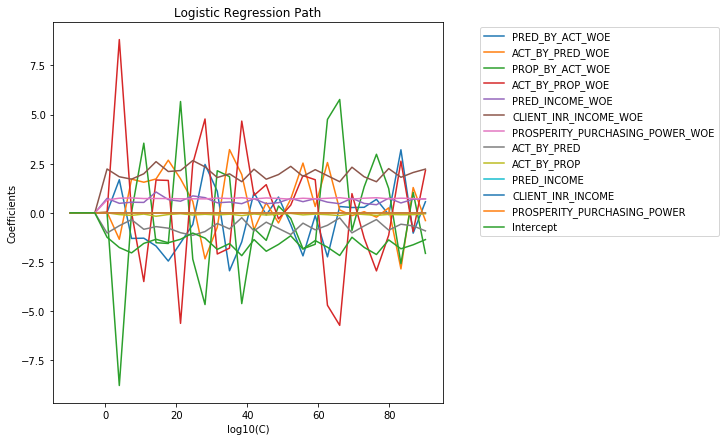

In [173]:
modelL1.draw_coeff_progression(cols_list_wo_hc, output_folder+'/l1path.png')

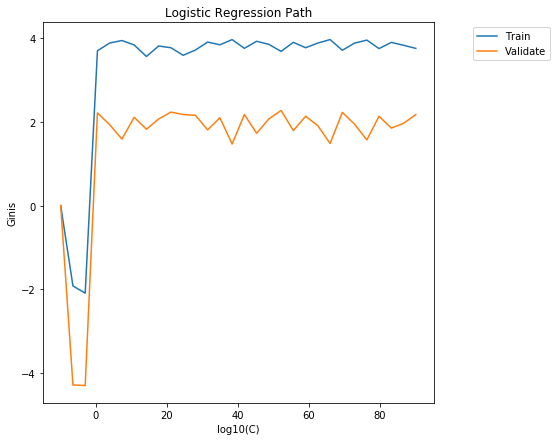

In [174]:
modelL1.draw_gini_progression(output_folder+'/l1gini.png')

In [64]:
print('Predictors in the model:',list(modelL1.final_predictors_))

Predictors in the model: ['PROSPERITY_PURCHASING_POWER']


In [65]:
model_filename1 = 'myModelL1'
pickle.dump(modelL1, open(model_filename1, 'wb'))

In [122]:
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression(penalty = 'l2', C=10000000000000000, class_weight='balanced')
comb.fit(df_train[["LOGIT_RISK_SCORE","PRED_INCOME"]],df_train["RISK_FSTQPD30"])


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10000000000000000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [123]:
comb.coef_


array([[7.90538060e-01, 1.06805566e-05]])

In [124]:
y_pred_comb_train=comb.predict_proba(df_train[["LOGIT_RISK_SCORE","PRED_INCOME"]])[:,1]
y_pred_comb_test=comb.predict_proba(df_test[["LOGIT_RISK_SCORE","PRED_INCOME"]])[:,1]


In [125]:
metric_auc_combined_train = metrics.roc_auc_score(df_train["RISK_FSTQPD30"], y_pred_comb_train)
metric_auc_combined_test = metrics.roc_auc_score(df_test["RISK_FSTQPD30"], y_pred_comb_test)

gini_combined_train = 2 * metric_auc_combined_train - 1

gini_combined_test = 2 * metric_auc_combined_test - 1

print("gini_combined_train:",'{:,.2%}'.format(gini_combined_train))

print("\ngini_combined_test:",'{:,.2%}'.format(gini_combined_test))

gini_combined_train: 31.50%

gini_combined_test: 25.04%


In [126]:
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression(class_weight='balanced')
comb.fit(df_train[cols_list_wo_hc],df_train["RISK_FSTQPD30"])
y_pred_comb_train=comb.predict_proba(df_train[cols_list_wo_hc])[:,1]
y_pred_comb_test=comb.predict_proba(df_test[cols_list_wo_hc])[:,1]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [127]:
metric_auc_combined_train = metrics.roc_auc_score(df_train["RISK_FSTQPD30"], y_pred_comb_train)
metric_auc_combined_test = metrics.roc_auc_score(df_test["RISK_FSTQPD30"], y_pred_comb_test)

gini_combined_train = 2 * metric_auc_combined_train - 1

gini_combined_test = 2 * metric_auc_combined_test - 1

print("gini_combined_train:",'{:,.2%}'.format(gini_combined_train))

print("\ngini_combined_test:",'{:,.2%}'.format(gini_combined_test))


gini_combined_train: 3.91%

gini_combined_test: 4.50%


In [128]:
cols_list_w_hc = cols_list_wo_hc+["LOGIT_RISK_SCORE"]
cols_list_w_hc

['PRED_BY_ACT_WOE',
 'ACT_BY_PRED_WOE',
 'PROP_BY_ACT_WOE',
 'ACT_BY_PROP_WOE',
 'PRED_INCOME_WOE',
 'CLIENT_INR_INCOME_WOE',
 'PROSPERITY_PURCHASING_POWER_WOE',
 'ACT_BY_PRED',
 'ACT_BY_PROP',
 'PRED_INCOME',
 'CLIENT_INR_INCOME',
 'PROSPERITY_PURCHASING_POWER',
 'LOGIT_RISK_SCORE']

In [138]:
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression(class_weight='balanced', C=10000)
comb.fit(df_train[cols_list_w_hc],df_train["RISK_FSTQPD30"])
y_pred_comb_train=comb.predict_proba(df_train[cols_list_w_hc])[:,1]
y_pred_comb_test=comb.predict_proba(df_test[cols_list_w_hc])[:,1]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [139]:
df_test["RISK_FSTQPD30"].value_counts()

0    338096
1     37818
Name: RISK_FSTQPD30, dtype: int64

In [140]:
metric_auc_combined_train = metrics.roc_auc_score(df_train["RISK_FSTQPD30"], y_pred_comb_train)
metric_auc_combined_test = metrics.roc_auc_score(df_test["RISK_FSTQPD30"], y_pred_comb_test)
gini_combined_train = 2 * metric_auc_combined_train - 1
gini_combined_test = 2 * metric_auc_combined_test - 1
print("gini_combined_train:",'{:,.2%}'.format(gini_combined_train))
print("\ngini_combined_test:",'{:,.2%}'.format(gini_combined_test))



gini_combined_train: 31.41%

gini_combined_test: 24.98%


In [134]:
comb.coef_

array([[ 1.65608255e-02,  1.65608255e-02,  2.60413347e-02,
         2.60413347e-02, -4.70879949e-01, -1.00235618e-01,
         1.46107867e-01,  1.34468037e+00,  2.36654588e-01,
         1.12733693e-04, -7.88393800e-05, -4.81874471e-07,
         7.80672921e-01]])

In [136]:
metric_auc_combined_train = metrics.roc_auc_score(df_train["RISK_FSTQPD30"], df_train["RISK_SCORE"])
metric_auc_combined_test = metrics.roc_auc_score(df_test["RISK_FSTQPD30"], df_test["RISK_SCORE"])
gini_combined_train = 2 * metric_auc_combined_train - 1
gini_combined_test = 2 * metric_auc_combined_test - 1
print("gini_combined_train:",'{:,.2%}'.format(gini_combined_train))
print("\ngini_combined_test:",'{:,.2%}'.format(gini_combined_test))


gini_combined_train: 31.49%

gini_combined_test: 24.90%
